In [2]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [3]:
# Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [4]:
# Diretório onde estão armazenadas as imagens
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [5]:
# Função para carregar e redimensionar imagens
def load_image(image_path, target_size=(56, 56)):
    try:
        if isinstance(image_path, str):
            image = Image.open(image_path)
            image = image.resize(target_size)
            return np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        else:
            raise ValueError("image_path must be a string representing the file path to the image.")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [6]:
# Carregar IDs do grupo de treinamento e validação de arquivos de texto
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\lower_resolution_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [7]:
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\lower_resolution_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [8]:
# Verificar se os IDs foram carregados corretamente
print(f"IDs de treinamento carregados: {train_ids[:5]} ... ({len(train_ids)} no total)")
print(f"IDs de validação carregados: {val_ids[:5]} ... ({len(val_ids)} no total)")

IDs de treinamento carregados: ['16078', '16831', '16073', '16072', '16830'] ... (3319 no total)
IDs de validação carregados: ['14175', '14176', '15540', '14172', '14678'] ... (1107 no total)


In [9]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [10]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 3318
Número de imagens de validação carregadas: 1106


In [11]:
# Separar as imagens e os rótulos (labels)
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [12]:
# Carregar as imagens
train_images = [load_image(image_path, target_size=(56, 56)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(56, 56)) for image_path in val_images]

In [13]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [14]:
# Converter os rótulos em formato adequado (numérico)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [16]:
# One-Hot Encoding dos rótulos
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [17]:
# Gerador de dados
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=16, target_size=(56, 56)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[i] for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [18]:
# Criar geradores para treinamento e validação
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=16)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=16)

In [19]:
# Carregar o modelo base VGG16 com pesos pré-treinados da ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

In [20]:
# Congelar as camadas da VGG16 para treinar apenas as camadas personalizadas
base_model.trainable = False

In [21]:
# Adicionar novas camadas no topo do modelo base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [22]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Descongelar as últimas camadas da VGG16 para fazer fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [24]:
# Recompilar o modelo 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [25]:
# Treinar o modelo
history_finetune = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=val_generator
)

Epoch 1/20
208/208 [==============================] - 90s 425ms/step - loss: 1.3685 - accuracy: 0.3954 - val_loss: 1.1066 - val_accuracy: 0.5235
Epoch 2/20
208/208 [==============================] - 97s 465ms/step - loss: 1.0828 - accuracy: 0.5241 - val_loss: 0.9980 - val_accuracy: 0.5181
Epoch 3/20
208/208 [==============================] - 95s 457ms/step - loss: 0.9821 - accuracy: 0.5856 - val_loss: 0.9557 - val_accuracy: 0.6230
Epoch 4/20
208/208 [==============================] - 96s 461ms/step - loss: 0.9148 - accuracy: 0.6133 - val_loss: 0.8606 - val_accuracy: 0.6528
Epoch 5/20
208/208 [==============================] - 96s 461ms/step - loss: 0.8505 - accuracy: 0.6522 - val_loss: 0.8715 - val_accuracy: 0.5986
Epoch 6/20
208/208 [==============================] - 97s 466ms/step - loss: 0.7868 - accuracy: 0.6872 - val_loss: 0.7548 - val_accuracy: 0.7016
Epoch 7/20
208/208 [==============================] - 95s 457ms/step - loss: 0.7465 - accuracy: 0.7004 - val_loss: 0.7172 - val_ac

In [26]:
# Salvar o modelo treinado
model.save('trained_model.vgg16_lower_resolution')

INFO:tensorflow:Assets written to: trained_model.vgg16_lower_resolution\assets


INFO:tensorflow:Assets written to: trained_model.vgg16_lower_resolution\assets


In [27]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

35/35 [==============================] - 8s 214ms/step - loss: 0.4350 - accuracy: 0.8300
Loss no conjunto de validação: 0.4349557161331177
Accuracy no conjunto de validação: 0.8300181031227112


In [28]:
# Matriz de confusão e relatório de classificação
from sklearn.metrics import confusion_matrix, classification_report

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

35/35 [==============================] - 8s 214ms/step
Matriz de Confusão:
[[ 21   0   3   3   0]
 [  1 156  10   4  21]
 [  0  21 401   8   8]
 [  0  26  38 230  17]
 [  0  20   1   7 110]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.95      0.78      0.86        27
    Classe 1       0.70      0.81      0.75       192
    Classe 2       0.89      0.92      0.90       438
    Classe 3       0.91      0.74      0.82       311
    Classe 4       0.71      0.80      0.75       138

    accuracy                           0.83      1106
   macro avg       0.83      0.81      0.81      1106
weighted avg       0.84      0.83      0.83      1106



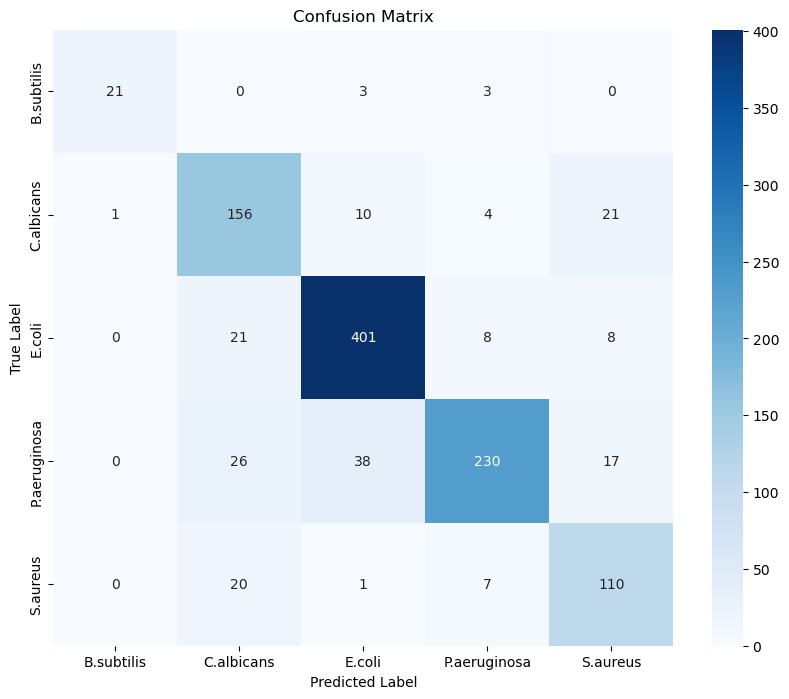

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()